In [7]:
import sncosmo
from   astropy.table import Table
import numpy as np
import matplotlib.pylab as plt

obs = Table({'time' : [56176.19, 56188.254, 56207.172],
             'band' : ['desg', 'desr', 'desi'],
             'gain' : [1., 1., 1.],
             'skynoise': [191.27, 147.62, 160.40],
             'zp'   : [30., 30., 30.],
             'zpsys':['ab', 'ab', 'ab']})

model  = sncosmo.Model(source='salt2')

### Reading SNTable in

In [33]:
filename = "/global/homes/a/anitab/DC2_run1p1_TransientDocs/Notebooks/Hosted_SN_table.csv"
from pandas import read_csv

In [49]:
vvv  = read_csv(filename)
data = vvv['galaxy_id c mB t0 x0 x1 z random_Hosting rand_host zbin "Unnamed: 0" diskMassStellar morphology/diskHalfLightRadiusArcsec morphology/diskMinorAxisArcsec morphology/positionAngle morphology/spheroidHalfLightRadiusArcsec morphology/spheroidMinorAxisArcsec size_bulge_true size_disk_true totalMassStellar uniqueId raJ2000_gal decJ2000_gal z zbin_gals snid']

In [55]:
vvv.columns

Index(['galaxy_id c mB t0 x0 x1 z random_Hosting rand_host zbin "Unnamed: 0" diskMassStellar morphology/diskHalfLightRadiusArcsec morphology/diskMinorAxisArcsec morphology/positionAngle morphology/spheroidHalfLightRadiusArcsec morphology/spheroidMinorAxisArcsec size_bulge_true size_disk_true totalMassStellar uniqueId raJ2000_gal decJ2000_gal z zbin_gals snid'], dtype='object')

In [229]:
length = 10000 #len(data)
zvals  = np.zeros(length) 
x0vals = np.zeros(length)
x1vals = np.zeros(length)
cvals  = np.zeros(length)
mBvals = np.zeros(length)
t0vals = np.zeros(length)
smass  = np.zeros(length)

for i in range(length):
    zvals[i]  = data[i].split()[6]
    x0vals[i] = data[i].split()[4]
    x1vals[i] = data[i].split()[5]
    cvals[i]  = data[i].split()[1]
    mBvals[i] = data[i].split()[2]
    t0vals[i] = data[i].split()[3]
    smass[i]  = data[i].split()[20]

In [97]:
"""
print (" z limits: ")
print (np.min(zvals))
print (np.max(zvals))
print ()

print (" x0 limits: ")
print (np.min(x0vals))
print (np.max(x0vals))
print ()

print (" x1 limits: ")
print (np.min(x1vals))
print (np.max(x1vals))
print ()

print (" c limits: ")
print (np.min(cvals))
print (np.max(cvals))
print ()

print (" mB limits: ")
print (np.min(mBvals))
print (np.max(mBvals))
print ()
"""

'\nprint (" z limits: ")\nprint (np.min(zvals))\nprint (np.max(zvals))\nprint ()\n\nprint (" x0 limits: ")\nprint (np.min(x0vals))\nprint (np.max(x0vals))\nprint ()\n\nprint (" x1 limits: ")\nprint (np.min(x1vals))\nprint (np.max(x1vals))\nprint ()\n\nprint (" c limits: ")\nprint (np.min(cvals))\nprint (np.max(cvals))\nprint ()\n\nprint (" mB limits: ")\nprint (np.min(mBvals))\nprint (np.max(mBvals))\nprint ()\n'

In [205]:
params = []
for j, z in enumerate(zvals):
    mabs = mBvals[j] #np.random.normal(-19.3, 0.3)
    model.set(z=z)
    model.set_source_peakabsmag(mabs, 'bessellb', 'ab')
    x0 = model.get('x0')
    p = {'z':z, 't0':t0vals[j], 'x0':x0, 'x1': x1vals[j], 'c': cvals[j]}
    params.append(p)

#for p in params:
#    print (p)

In [206]:
lcs = sncosmo.realize_lcs(obs, model, params)
print (lcs[0])

   time   band      flux     fluxerr  zp  zpsys
--------- ---- ------------- ------- ---- -----
 56176.19 desg 224.983217454  191.27 30.0    ab
56188.254 desr 22.9147876598  147.62 30.0    ab
56207.172 desi 93.7390698543   160.4 30.0    ab


In [238]:
from   astropy.cosmology import WMAP9 as cosmo
import astropy.units as u

def mu2(x0, x1, c,z, smassval):
    alpha  = 0.141
    beta   = 3.101
    DeltaM = -0.07
    mB     = 10.635 - (2.5 * np.log(x0))
    dist   = cosmo.comoving_distance(lcs[0].meta['z'])
    dist  *= (1./u.Mpc)
    if smassval < 1e10:
        MB = -19.05
    else:
        MB = -19.05 + DeltaM
    val   = mB - (MB - (alpha * x1) + (beta * c))
    return val

Adding the condition on stellar mass did not change the distance modulus by anything noticable since the difference between MB value when considering stellar mass of the host galaxy or not was very small so it was expected, unfortunately!

In [239]:
vals = np.zeros(length)
zs   = np.zeros(length)
x0s  = np.zeros(length)
x1s  = np.zeros(length)
cs   = np.zeros(length)

mu = np.vectorize(mu2)

for i in range(length):
    vals[i] = mu(lcs[i].meta['x0'], lcs[i].meta['x1'], lcs[i].meta['c'], lcs[i].meta['z'], smass[i])
    zs[i]   = lcs[i].meta['z']
    x0s[i]  = lcs[i].meta['x0']
    x1s[i]  = lcs[i].meta['x1']
    cs[i]   = lcs[i].meta['c']

In [240]:
np.min(zs)

0.033126589233066606

### Distance modulus from theory

In [201]:
from   scipy              import interpolate, integrate

h  = 0.6726
H0 = h*100.

def chi_integrand(zprime):
    '''
    Parameters
    -------------------------------------------------------------------------------------------------
        zprime: redshift values
        
    Return
    -------------------------------------------------------------------------------------------------
        Integrand of integral part in luminosity distance in Equation (3) in Kosowsky 2011.
        d(zprime)/ E(zprime)
    '''

    omegam = 0.316
    omegav = 0.684
    val    = 1./(np.sqrt(omegam*(1+zprime)**3 + omegav))
    return val

def chi_integral(z):
    '''
    Parameters
    -------------------------------------------------------------------------------------------------
        z: redshift
        
    Return
    -------------------------------------------------------------------------------------------------
        Integral of the integral in luminsoty distance in Equation (3) in Kosowsky 2011.
        d(zprime)/ E(zprime) integrated from 0 to z
    '''
    
    c       = 3e5 #km/s
    val,err = integrate.quad(chi_integrand,0,z)
    return val

def mu_kosowsky(z):
    '''
    Parameters
    -------------------------------------------------------------------------------------------------
        z: redshift
        
    Return
    -------------------------------------------------------------------------------------------------
        Distance modulus (mu) obtained from Equation (2) in Kosowsky
    '''
    
    c   = 3e5
    righthandside = (1+z) * (c/H0) * chi_integral(z)
    val = 2.17 * np.log(righthandside) + 25.
    return val

#### 3rd polynomial fit to points

In [241]:
z = np.polyfit(np.sort(zs), vals[Z], 3)
p = np.poly1d(z)

#### Plotting mu(z) vs z from SNTable 

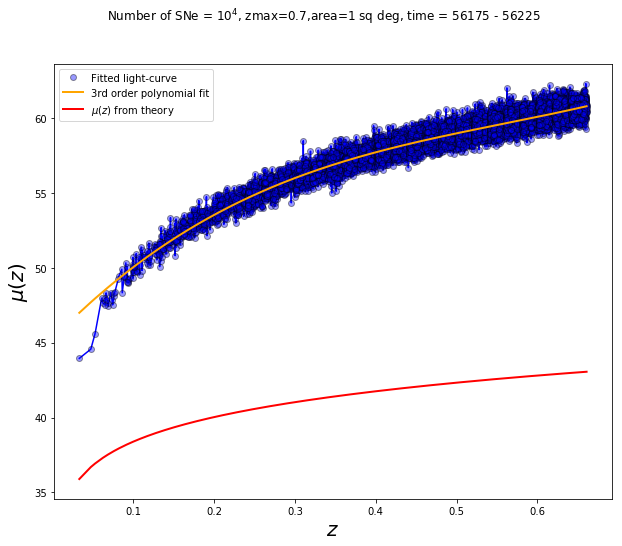

In [242]:
plt.figure(4, figsize=(10,8))

indx = np.arange(0,length)
Z = [x for _,x in sorted(zip(zvals,indx))]

# SNTable points fitted
plt.plot(np.sort(zs), vals[Z], "b", label="")
plt.plot(zs, vals, "bo", alpha=0.4, markeredgecolor="black", label="Fitted light-curve")

plt.xlabel("$z$", fontsize=20)
plt.ylabel("$\mu(z)$", fontsize=20)
plt.suptitle("Number of SNe = $10^4$, zmax=0.7,area=1 sq deg, time = 56175 - 56225")

# polynomial fit curve
plt.plot(np.sort(zs), p(np.sort(zs)), color="orange", lw=2, label="3rd order polynomial fit")

# theory curve
mu_kosowsky_vec = np.vectorize(mu_kosowsky)
plt.plot(np.sort(zs), mu_kosowsky_vec(np.sort(zs)), color="red", lw=2, label="$\mu(z)$ from theory")
plt.legend(loc='best')

#plt.savefig("mu_z_sne_params_SNTable.png", dpi=800)


#### Checking $\mu(z)$ values to compare with JLA

In [219]:
print ("mu(z=0.1) = ", mu_kosowsky(0.1))
print ("mu(z=0.2) = ", mu_kosowsky(0.2))
print ("mu(z=0.4) = ", mu_kosowsky(0.4))
print ("mu(z=0.6) = ", mu_kosowsky(0.6))

mu(z=0.1) =  38.3917370152
mu(z=0.2) =  40.029178781
mu(z=0.4) =  41.7514943145
mu(z=0.6) =  42.8012034255


Comparing this with values from JLA (http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html) shows that my distance modulus plot is in agreement with actual supernovae data so I am convinced that this function works 